# Fie Upon Thee, Autocorrect!

<img src="img/shakespeare.jpg" width="200">

<br><br><br>

## Recap of yesterday

I'll just leave this here so we can refer back to it.

* Quantitative data analysts distinguish between **measurements**, which are direct observations or outcomes of experiments, and **models**, which are mathematical machines that describe, predict, or explain the measurements in a quantitative way.
* Measurements can be expressed as points in an **N-dimensional space**. Since the number of measurements is finite, they can't completely fill the space.
  * Measurements can be represented in a 2-D data frame or 2-D array, in which the rows are repeated observations or experiments and the columns are observed attributes, one column/dimension per attribute.
  * Measurements can be visualized as a `scatter` plot.
  * Measurements say what _is_ true.
* Models, when questioned, provide a response for any point in the **N-dimensional space**, so a model completely fills the space.
  * Models can be represented in an N-dimensional array, as a value for each point in space, or as a function that returns a response for N arguments.
  * Models can be visualized by coloring a space with `imshow` or `contourf`, or with contour lines (like mountains on an elevation map).
  * The model-function's response may be
    * the probability that that combination of attributes exists, or
    * a prediction of some other attribute (or its probability), or
    * a category that we use to organize the data but isn't directly measurable, such as species (or its probability).
  * Models say what _would be_ true, under the given conditions, assuming that the model is accurate, etc.
* Models are algorithms involving numerical and categorical values: changing these values changes the model.
  * **Parameters** are values that we tune in an automated **fitting** procedure to find the best model for some measurements.
  * **Hyperparameters** are not part of the fitting procedure, but also impact the quality of the fitted model.
  * Models that don't accurately resemble their training data are **underfitted**.
  * Models that are too similar to their training data (take the individual points too literally—don't generalize well) are **overfitted**.
  * Both underfitting and overfitting are problematic.
* **Machine learning** is a fitting procedure, usually with very large datasets and very large numbers of parameters.
* A **neural network** is currently the most successful kind of machine learning model.
  * A neural network consists of layers of linear functions with many parameters sandwiched between non-linear functions.
  * Optimizing a neural network involves tuning the parameters of the linear functions so that the whole model fits the training data.
  * **Deep learning** is a neural network with many layers (which became feasible about 10 years ago).

<br><br><br>

## What we'll do today

Short discussion of categorical variables with the penguins.

A more detailed look at text-based data using the complete works of Shakespeare.

Build an autocomplete engine, learning a little about SQL and databases along the way.

Talk about the similarities and differences between our autocomplete engine and large language models like ChatGPT.

<br><br><br>

## Categorical variables among the penguins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
penguins = pd.read_csv("data/penguins.csv")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


<br><br><br>

In [3]:
penguins[["species", "island", "sex"]]

,species,island,sex
0,Adelie,Torgersen,male
1,Adelie,Torgersen,female
2,Adelie,Torgersen,female
3,Adelie,Torgersen,NaN
4,Adelie,Torgersen,female
...,...,...,...
339,Chinstrap,Dream,male
340,Chinstrap,Dream,female
341,Chinstrap,Dream,male
342,Chinstrap,Dream,male


In [4]:
penguins["species"].unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

In [5]:
penguins["island"].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [6]:
penguins["sex"].unique()

array(['male', 'female', nan], dtype=object)

<br><br><br>

Many (not all!) machine learning models require inputs and outputs to be numerical. How can we do that?

<br><br><br>

### Method 1

Associate a number to each category. We've already done this.

In [7]:
pd.Categorical(penguins["species"]).codes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
pd.Categorical(penguins["island"]).codes

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
pd.Categorical(penguins["sex"]).codes

array([ 1,  0,  0, -1,  0,  1,  0,  1, -1, -1, -1, -1,  0,  1,  1,  0,  0,
        1,  0,  1,  0,  1,  0,  1,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,
        0,  1,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  1, -1,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
        1,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  0,  1,  0,
        1,  0,  1,  1,  0,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,
        0,  1,  1,  0,  0,  1,  0,  1, -1,  1,  0,  1,  1,  0,  0,  1,  0,
        1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  0,  1,  0,  1,
        0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1, -1,  1,  0,
        1,  0,  1,  1,  0

<br><br><br>

Notice that this plot is using a numerical relationship among Adelie, Gentoo, and Chinstrap to give the horizontal axis an order (Adelie first, then Gentoo, then Chinstrap).

<Axes: xlabel='species'>

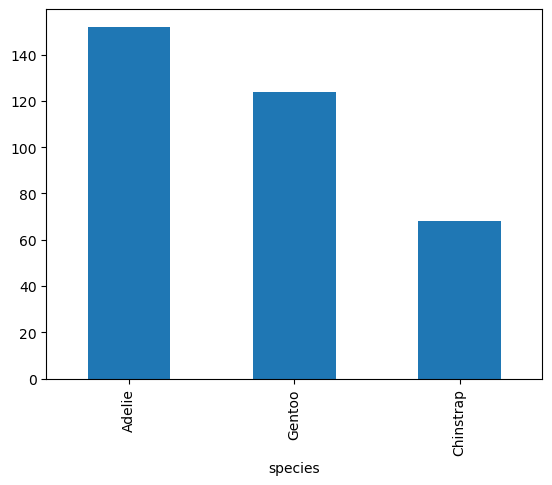

In [10]:
penguins["species"].value_counts().plot(kind="bar")

In [11]:
pd.crosstab(penguins["species"], penguins["island"])

island,Biscoe,Dream,Torgersen
species,,,
Adelie,44,56,52
Chinstrap,0,68,0
Gentoo,124,0,0


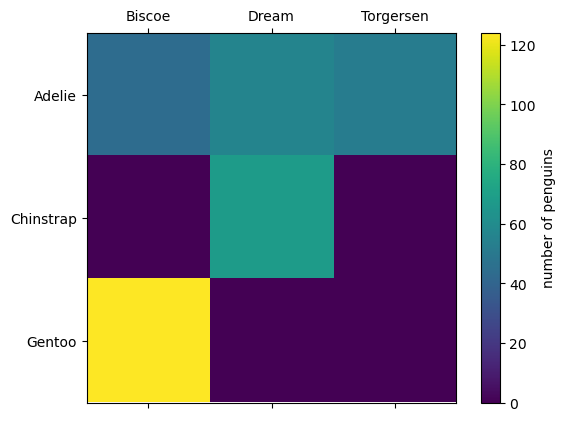

In [12]:
fig, ax = plt.subplots()

matrix = ax.matshow(pd.crosstab(penguins["species"], penguins["island"]).values)
fig.colorbar(matrix, label="number of penguins")

ax.set_xticks([0, 1, 2], ["Biscoe", "Dream", "Torgersen"])
ax.set_yticks([0, 1, 2], ["Adelie", "Chinstrap", "Gentoo"])

None

<br><br><br>

The disadvantage of this method is that the order is not meaningful—it's something we made up—and a machine learning model might optimize for it.

It's an invitation to overfitting (which can be controlled, but still).

<br><br><br>

### Method 2

Create a dimension for each value of a categorical variable:

In [13]:
expanded_penguins = pd.get_dummies(penguins.dropna(), columns=["species", "island", "sex"])
expanded_penguins

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,39.1,18.7,181.0,3750.0,2007,True,False,False,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,2007,True,False,False,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,2007,True,False,False,False,False,True,True,False
4,36.7,19.3,193.0,3450.0,2007,True,False,False,False,False,True,True,False
5,39.3,20.6,190.0,3650.0,2007,True,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2009,False,True,False,False,True,False,False,True
340,43.5,18.1,202.0,3400.0,2009,False,True,False,False,True,False,True,False
341,49.6,18.2,193.0,3775.0,2009,False,True,False,False,True,False,False,True
342,50.8,19.0,210.0,4100.0,2009,False,True,False,False,True,False,False,True


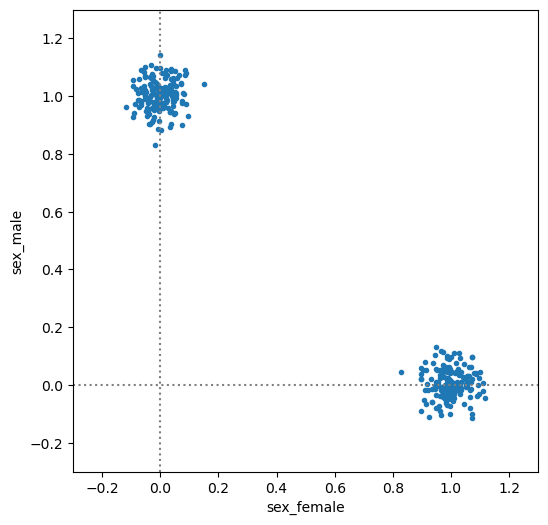

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

sex2D = expanded_penguins[["sex_female", "sex_male"]].values

# scatter a little, so we can see overlapping points
sex2D = sex2D.astype(np.float64) + np.random.normal(0, 0.05, (len(expanded_penguins), 2))

ax.scatter(sex2D[:, 0], sex2D[:, 1], marker=".")

ax.set_xlim(-0.3, 1.3)
ax.set_ylim(-0.3, 1.3)
ax.set_xlabel("sex_female")
ax.set_ylabel("sex_male")
ax.axhline(0, color="gray", ls=":")
ax.axvline(0, color="gray", ls=":")

None

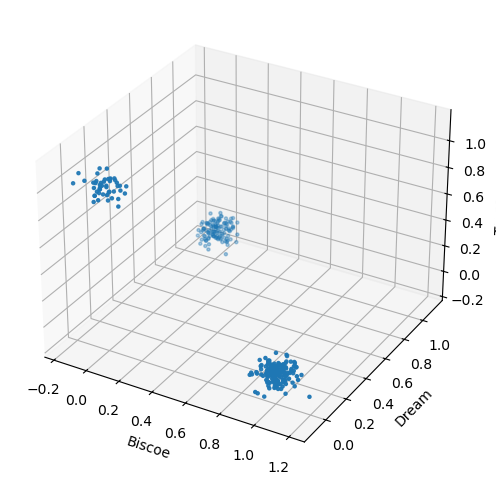

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")

island3D = expanded_penguins[["island_Biscoe", "island_Dream", "island_Torgersen"]].values

# scatter a little, so we can see overlapping points
island3D = island3D.astype(np.float64) + np.random.normal(0, 0.05, (len(expanded_penguins), 3))

ax.scatter(island3D[:, 0], island3D[:, 1], island3D[:, 2], marker=".")

ax.set_xlabel("Biscoe")
ax.set_ylabel("Dream")
ax.set_zlabel("Torgersen")

None

<br><br><br>

The disadvantages of this method are that

* we quickly end up with a lot of dimensions, which uses more memory and computation time, and
* all the values between and beyond 0 and 1 are meaningless.

But if you can afford it, it's a robust way to make models!

<br><br><br>

## Dataset: the complete works of Shakespeare

This used to be a big dataset, used to illustrate large storage devices, like in [this definition of CD-ROM](https://vintageapple.org/apple_ii/pdf/Apple_IIGS__Ownwers_Guide_1986.pdf) from 1986:

<img src="img/shakespeare-a-big-dataset.png" width="600">

Now it's small enough to easily load in JupyterLite but is still big enough to be interesting.

<br><br><br>

This file comes from Project Gutenberg, [ebook #100](https://www.gutenberg.org/ebooks/100):

In [16]:
with open("data/shakespeare.txt") as file:
    corpus = file.read()

In [17]:
len(corpus)

5367503

In [18]:
len(corpus) / 1e6

5.367503

5.36 MB (a whole laser disk, apparently).

<br><br><br>

In [19]:
print(corpus[100000:101000])

ok up that fire,
Which many legions of true hearts had warmed,
And so the general of hot desire,
Was sleeping by a virgin hand disarmed.
This brand she quenched in a cool well by,
Which from Love’s fire took heat perpetual,
Growing a bath and healthful remedy,
For men diseased; but I, my mistress’ thrall,
  Came there for cure and this by that I prove,
  Love’s fire heats water, water cools not love.

THE END

ALL’S WELL THAT ENDS WELL

Contents

ACT I
Scene I. Rossillon. A room in the Countess’s palace.
Scene II. Paris. A room in the King’s palace.
Scene III. Rossillon. A Room in the Palace.

ACT II
Scene I. Paris. A room in the King’s palace.
Scene II. Rossillon. A room in the Countess’s palace.
Scene III. Paris. The King’s palace.
Scene IV. Paris. The King’s palace.
Scene V. Another room in the same.

ACT III
Scene I. Florence. A room in the Duke’s palace.
Scene II. Rossillon. A room in the Countess’s palace.
Scene III. Florence. Before the Duke’s palace.
Scene IV. Rossillon. A room

<br><br><br>

What distinct characters does it have?

In [20]:
set(corpus)

{'\n',
 ' ',
 '!',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'À',
 'Æ',
 'Ç',
 'É',
 'à',
 'â',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'î',
 'œ',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '•',
 '…',
 '™'}

<br><br><br>

## How often is "t" followed by "h"?

In [91]:
first_character = []
next_character = []
for i in range(len(corpus) - 1):
    first_character.append(corpus[i])
    next_character.append(corpus[i + 1])

In [92]:
first_character[100414:100439]

['A',
 'L',
 'L',
 '’',
 'S',
 ' ',
 'W',
 'E',
 'L',
 'L',
 ' ',
 'T',
 'H',
 'A',
 'T',
 ' ',
 'E',
 'N',
 'D',
 'S',
 ' ',
 'W',
 'E',
 'L',
 'L']

In [93]:
next_character[100414:100439]

['L',
 'L',
 '’',
 'S',
 ' ',
 'W',
 'E',
 'L',
 'L',
 ' ',
 'T',
 'H',
 'A',
 'T',
 ' ',
 'E',
 'N',
 'D',
 'S',
 ' ',
 'W',
 'E',
 'L',
 'L',
 '\n']

<br><br><br>

In [94]:
pairs = pd.crosstab(first_character, next_character, rownames=["first"], colnames=["next"])
pairs

next,\n,,!,#,$,%,&,(,),*,...,î,œ,—,‘,’,“,”,•,…,™
first,,,,,,,,,,,,,,,,,,,,,
\n,40969,5771,0,0,0,0,1,87,0,1,...,0,0,4,124,759,451,0,0,0,0
,17,13998,0,1,1,0,47,143,0,9,...,0,0,0,244,2182,768,26,4,1,0
!,4199,3247,0,0,0,0,0,0,11,0,...,0,0,161,28,9,0,151,0,0,0
#,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
“,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,10,0,0,0,0,0
”,366,490,11,0,0,0,0,0,1,0,...,0,0,24,0,0,0,0,0,0,0
•,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
sorted_by_columns = pairs[pairs.sum(axis=0).sort_values(ascending=False).index]

In [96]:
sorted_by_both = sorted_by_columns.loc[sorted_by_columns.sum(axis=1).sort_values(ascending=False).index]

In [97]:
sorted_by_both

next,,e,t,o,a,h,s,n,r,i,...,ê,À,•,ë,…,î,$,â,%,#
first,,,,,,,,,,,,,,,,,,,,,
,13998,11431,108892,36760,67930,54535,57215,23277,11327,34686,...,4,0,4,0,1,0,1,0,0,1
e,130887,18062,15220,1268,29347,742,32472,35541,58595,5898,...,0,0,0,0,0,0,0,0,0,0
t,77611,24136,4566,26682,9663,105156,5414,392,9215,13740,...,0,0,0,0,0,0,0,0,0,0
o,37233,1400,18966,12789,1634,408,7563,31871,38574,2129,...,0,0,0,0,0,1,0,0,0,0
a,14165,606,37901,48,3,189,19251,51306,32513,11734,...,0,0,0,4,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
î,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
$,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
â,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


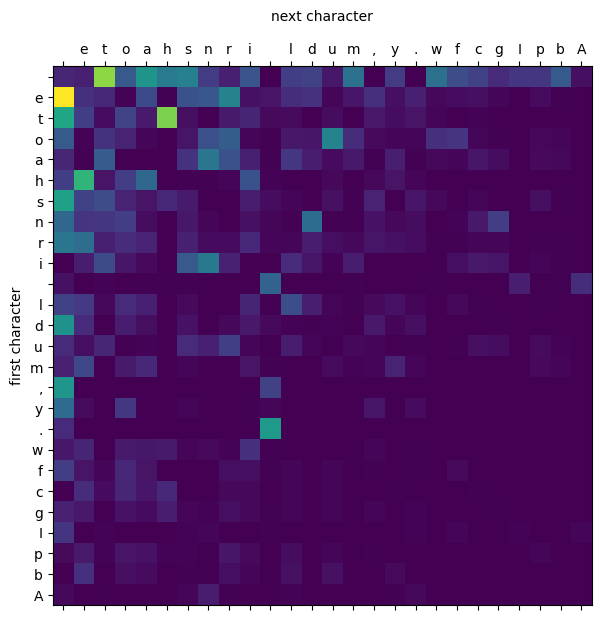

In [100]:
fig, ax = plt.subplots(figsize=(7, 7))

matrix = ax.matshow(sorted_by_both.values)

ax.set_xticks(range(len(sorted_by_both.index)), sorted_by_both.index)
ax.set_yticks(range(len(sorted_by_both.columns)), sorted_by_both.columns)

ax.set_xlim(-0.5, 25.5)
ax.set_ylim(-0.5, 25.5)
ax.set_ylabel("first character")
ax.set_xlabel("next character")
ax.xaxis.set_label_position("top")
plt.gca().invert_yaxis()

None

<br><br><br>

The bright spots are

In [112]:
pairs.loc["e", " "]   # e followed by space (at the end of a word)

130887

In [113]:
pairs.loc[" ", "t"]   # space followed by t (at the beginning of a word)

108892

In [115]:
pairs.loc["t", "h"]   # t followed by h

105156

In [116]:
pairs.loc[".", " "]   # period followed by space (at the end of a sentence)

15578

<br><br><br>

## Sequence of characters → sequence of words

We could build a per-letter autocomplete algorithm that would see "t" and suggest "h", but it wouldn't produce interesting text.

It gets more interesting if we do this at the word level.

The first step of **parsing**, an analysis of human-readable text, is **tokenizing** the input: turning raw characters into **tokens**.

Why "tokens" and not "words"? Some of our tokens will be punctuation marks, so that when your autocomplete algorithm sees `hark` it can suggest a token like `!`.

<br><br><br>

**Regular expressions** or **regex** is a mini-language for recognizing strings and parts of strings.

In [117]:
import re

In [152]:
#               "’" for "thou be’st" and "-" for "a-foot"       multi-digit number as a token
#                olden-time (and French) letters     🡓    "&c."  🡓  "+" matches sequences of at least 1 character
#        capital and lowercase letters       🡓       🡓     🡓     🡓  🡓   match any single character that is not (^) a space
#                                  🡓         🡓       🡓     🡓     🡓  🡓   🡓
recognize_token = re.compile("([A-Za-zÀÆÇÉàâæçèéêëîœ’-]+|&c\.|[0-9]+|[^ ])")
#                            🡑                          🡑    🡑      🡑
#              "(" and ")" form a group               "|" means "or"

In [153]:
recognize_token.findall("Dost thou be’st 007 tokëns, &c.?")

['Dost', 'thou', 'be’st', '007', 'tokëns', ',', '&c.', '?']

<br><br><br>

In [150]:
for match in recognize_token.finditer(corpus):
    token = match.group(0)
    print(repr(token))
    if token == ".":
        break

'The'
'Project'
'Gutenberg'
'eBook'
'of'
'The'
'Complete'
'Works'
'of'
'William'
'Shakespeare'
'\n'
'\n'
'This'
'ebook'
'is'
'for'
'the'
'use'
'of'
'anyone'
'anywhere'
'in'
'the'
'United'
'States'
'and'
'\n'
'most'
'other'
'parts'
'of'
'the'
'world'
'at'
'no'
'cost'
'and'
'with'
'almost'
'no'
'restrictions'
'\n'
'whatsoever'
'.'


<br><br><br>

In [138]:
tokens = []
for match in recognize_token.finditer(corpus):
    tokens.append(match.group(0))

In [139]:
len(corpus)

5367503

In [140]:
len(tokens)

1399006

<br><br><br>

In [142]:
len(set(corpus))

103

In [143]:
len(set(tokens))

36775

Instead of a 103×103 table of "first", "next" pairs, this would be a 36775×36775 table. Too big!

<br><br><br>

## SQL, the language of table manipulation

Just as **regular expression** is a mini-language that we can call from Python to handle strings, **SQL** is a mini-language to deal with tables.

In [144]:
import sqlite3

In [164]:
db = sqlite3.connect(":memory:")
db.execute("CREATE TABLE works(title TEXT, type TEXT, characters INTEGER, year_low INTEGER, year_high INTEGER)")

<br><br><br>

(Don't take the following data too seriously; I got it from ChatGPT.)

In [165]:
data_in_python = [
    ["The Sonnets", "poetry", None, 1609, 1609],
    ["All’s Well that Ends Well", "comedy", 23, 1604, 1605],
    ["The Tragedy of Antony and Cleopatra", "tragedy", 42, 1606, 1606],
    ["As You Like It", "comedy", 27, 1599, 1600],
    ["The Comedy of Errors", "comedy", 18, 1594, 1594],
    ["The Tragedy of Coriolanus", "tragedy", 30, 1608, 1608],
    ["Cymbeline", "mixed", 20, 1609, 1610],
    ["The Tragedy of Hamlet, Prince of Denmark", "tragedy", 30, 1599, 1601],
    ["The First Part of King Henry the Fourth", "history", 25, 1596, 1597],
    ["The Second Part of King Henry the Fourth", "history", 25, 1597, 1598],
    ["The Life of King Henry the Fifth", "history", 30, 1599, 1599],
    ["The First Part of Henry the Sixth", "history", 40, 1590, 1592],
    ["The Second Part of King Henry the Sixth", "history", 30, 1590, 1591],
    ["The Third Part of King Henry the Sixth", "history", 30, 1591, 1591],
    ["King Henry the Eighth", "history", 30, 1612, 1613],
    ["The Life and Death of King John", "history", 20, 1596, 1596],
    ["The Tragedy of Julius Caesar", "tragedy", 40, 1599, 1599],
    ["The Tragedy of King Lear", "tragedy", 20, 1605, 1606],
    ["Love’s Labour’s Lost", "comedy", 23, 1594, 1595],
    ["The Tragedy of Macbeth", "tragedy", 20, 1606, 1606],
    ["Measure for Measure", "comedy", 20, 1603, 1604],
    ["The Merchant of Venice", "comedy", 22, 1596, 1597],
    ["The Merry Wives of Windsor", "comedy", 24, 1597, 1597],
    ["A Midsummer Night’s Dream", "comedy", 21, 1595, 1596],
    ["Much Ado About Nothing", "comedy", 23, 1598, 1599],
    ["The Tragedy of Othello, the Moor of Venice", "tragedy", 21, 1603, 1604],
    ["Pericles, Prince of Tyre", "late romance", 20, 1607, 1608],
    ["King Richard the Second", "history", 20, 1595, 1595],
    ["King Richard the Third", "history", 30, 1592, 1593],
    ["The Tragedy of Romeo and Juliet", "tragedy", 20, 1595, 1595],
    ["The Taming of the Shrew", "comedy", 16, 1590, 1592],
    ["The Tempest", "late romance", 12, 1610, 1611],
    ["The Life of Timon of Athens", "tragedy", 20, 1605, 1606],
    ["The Tragedy of Titus Andronicus", "tragedy", 25, 1591, 1592],
    ["Troilus and Cressida", "mixed", 30, 1601, 1602],
    ["Twelfth Night; or, What You Will", "comedy", 18, 1601, 1602],
    ["The Two Gentlemen of Verona", "comedy", 20, 1589, 1593],
    ["The Two Noble Kinsmen", "comedy", 20, 1613, 1614],
    ["The Winter’s Tale", "comedy", 21, 1609, 1611],
    ["A Lover’s Complaint", "poetry", None, 1609, 1609],
    ["The Passionate Pilgrim", "poetry", None, 1599, 1599],
    ["The Phoenix and the Turtle", "poetry", None, 1601, 1601],
    ["The Rape of Lucrece", "poetry", 2, 1594, 1594],
    ["Venus and Adonis", "poetry", 2, 1593, 1593],
]

In [166]:
db.executemany("INSERT INTO works VALUES(?, ?, ?, ?, ?)", data_in_python)
db.commit()

<br><br><br>

Although SQL will be more computationally efficient for what we want to do, it doesn't have a convenient way to print out and look at a table.

But we can dump it into Pandas and view it there.

`SELECT` means select columns (not rows), and `*` means "everything".

In [167]:
pd.read_sql("SELECT * FROM works", db)

,title,type,characters,year_low,year_high
0,The Sonnets,poetry,NaN,1609,1609
1,All’s Well that Ends Well,comedy,23.0,1604,1605
2,The Tragedy of Antony and Cleopatra,tragedy,42.0,1606,1606
3,As You Like It,comedy,27.0,1599,1600
4,The Comedy of Errors,comedy,18.0,1594,1594
5,The Tragedy of Coriolanus,tragedy,30.0,1608,1608
6,Cymbeline,mixed,20.0,1609,1610
7,"The Tragedy of Hamlet, Prince of Denmark",tragedy,30.0,1599,1601
8,The First Part of King Henry the Fourth,history,25.0,1596,1597
9,The Second Part of King Henry the Fourth,history,25.0,1597,1598


<br><br><br>

Mathematical manipulations, such as `year_uncertainty` = `year_high - year_low`.

In [168]:
pd.read_sql("SELECT title, year_high - year_low AS year_uncertainty FROM works", db)

,title,year_uncertainty
0,The Sonnets,0
1,All’s Well that Ends Well,1
2,The Tragedy of Antony and Cleopatra,0
3,As You Like It,1
4,The Comedy of Errors,0
5,The Tragedy of Coriolanus,0
6,Cymbeline,1
7,"The Tragedy of Hamlet, Prince of Denmark",2
8,The First Part of King Henry the Fourth,1
9,The Second Part of King Henry the Fourth,1


<br><br><br>

`WHERE` selects rows (not columns) by value.

In [169]:
pd.read_sql("SELECT * FROM works WHERE type = 'tragedy'", db)

,title,type,characters,year_low,year_high
0,The Tragedy of Antony and Cleopatra,tragedy,42,1606,1606
1,The Tragedy of Coriolanus,tragedy,30,1608,1608
2,"The Tragedy of Hamlet, Prince of Denmark",tragedy,30,1599,1601
3,The Tragedy of Julius Caesar,tragedy,40,1599,1599
4,The Tragedy of King Lear,tragedy,20,1605,1606
5,The Tragedy of Macbeth,tragedy,20,1606,1606
6,"The Tragedy of Othello, the Moor of Venice",tragedy,21,1603,1604
7,The Tragedy of Romeo and Juliet,tragedy,20,1595,1595
8,The Life of Timon of Athens,tragedy,20,1605,1606
9,The Tragedy of Titus Andronicus,tragedy,25,1591,1592


<br><br><br>

`GROUP BY` aggregates the data, such as counting, adding, and finding the minimum or maximum.

In [173]:
pd.read_sql("SELECT type, COUNT(*) AS number, SUM(characters), MIN(year_low), MAX(year_high) FROM works GROUP BY type", db)

,type,number,SUM(characters),MIN(year_low),MAX(year_high)
0,comedy,14,296,1589,1614
1,history,10,280,1590,1613
2,late romance,2,32,1607,1611
3,mixed,2,50,1601,1610
4,poetry,6,4,1593,1609
5,tragedy,10,268,1591,1608


<br><br><br>

## Fie Upon Thee, Autocomplete!